In [15]:
# imported packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

print("packages imported")

packages imported


# Problem Statement

Construct a mathematical model to estimate the **total annual income** of Loafe Café at both the Alumni Centre and Sauder locations as a function of daily temperature, daily precipitation, daily humidity and frequency of customers.

# Variables and Parameters

| Symbol | Description | Type | Dimension | Units |
|---|---|---|---|---|
| $d$ | day index within a (non-leap) year, $d \in \{1, \dots, 365\}$ | independent variable | 1 | — |
| $T_d,P_d,H_d$ | temperature, precipitation, humidity on day $d$ | independent variable (weather input) | $T,L,1$ | °C,mm,% |
| $C_d$ | expected total customers on day $d$ (both locations) | dependent variable (model output) | 1 | customers/day |
| $s$ | average spend per customer | parameter | 1 | CAD/customer |
| $R$ | total annual income | derived aggregate output | 1 | CAD/year |
| $T_0,P_0,H_0$ | reference temperature, precipitation, humidity level | parameter (reference level) | $T,L,1$ | °C,mm,% |
| $C_0$ | baseline customers at reference weather $(T_0, P_0, H_0)$ | parameter | 1 | customers/day |
| $a$ | rate of change of customers w.r.t temperature (squared) | parameter (sensitivity) | $T^{-2}$ | customers / (°C)$^2$ |
| $b$ | rate of change of customers w.r.t precipitation | parameter (sensitivity) | $L^{-1}$ | customers / mm |
| $c$ | rate of change of customers w.r.t humidity (squared) | parameter (sensitivity) | 1 | customers / (%)$^2$ |


# Assumptions and Constraints:


- The number of customers is non-negative and proportional to temperature squared, precipitation, and humidity squared.
- Annual revenue linearly scales with the number of customers per year.
- The average amount of money individual customers spend remains constant all year round.
- On average, customers at the Alumni Centre spend the same amount of money as customers at the Sauder building. This allows us to combine the customer data of the two.
- To evaluate the potential correlation of weather to customer visits, we do not account for external factors such as the school year schedule.
- For usage of this model in current and future years, we assume that weather trends each month remain the same in 2025 and onwards.
- We assume weather trends are different each month, so we will construct separate probability density functions for each to estimate customer visits over the whole year more accurately.
- A a typical non-leap year with 365 days can be used to model annual revenue.
- Leap years are included in the data we use to build the model, but since we sample from each month’s pool of data without consideration for what specific day it is, we can still take 365 samples to make a total customer estimate for a non-leap year.
- Reference values are the mean values taken from the entire dataset, as these are the points from which deviating weather measurements would cause a difference in the expected number of customers.

# Building the Solution:

We estimate total annual revenue of Loafe by:
1) Loading the provided datasets and doing some light exploratory data analysis.  
2) Constructing probability density functions for temperature, precipitation, and humidity ($T,P,H$) for each month. We achieve this with kernel density estimation over the data set using a gaussian kernel.  
3) Estimate the parameters of the daily customers equation from data. 
- Estimate $a,b,c,c_0$ using the January/July customer dataset.
- Estimate $t_0,p_0,h_0$ using the entire weather dataset.
4) Simulate a year of revenue by sampling weather conditions for each day (ex. if a day is in March then we sample $(T_d,P_d,H_d)$ off of each respective March PDF). We then use those weather samples $(T_d,P_d,H_d)$ as inputs to the daily customer function and then multiply the daily customers by an average purchase amount. We do this over all 365 days of the year.
5) Finally, we perform uncertainty analysis via Monte Carlo methods on our yearly revenue calculations to get a range of plausible values.

**Data processing**

In the code cell below we combine both Loafe locations customer data into a January total and a July total respectively.   

In [16]:
# load data
cust_data = pd.read_csv("customer_data_2025.csv")
cust = pd.DataFrame(cust_data)
weather_data = pd.read_csv("weatherstats_vancouver_daily_2025.csv")  
weather = pd.DataFrame(weather_data)

# jan/jul customer totals across both locations
cust["Jan_total"] = cust["January_Frequency_Customers_Alumni_Centre"].fillna(0) + cust["January_Frequency_Customers_Sauder"].fillna(0)
cust["Jul_total"] = cust["July_Frequency_Customers_Alumni_Centre"].fillna(0) + cust["July_Frequency_Customers_Sauder"].fillna(0)

**Build monthly PDFs**

We split weather data by month and fit Gaussian KDEs for temperature, precipitation, and humidity. We use KDEs to build these monthly weather PDFs (for temperature, precipitation, humidity) because KDEs give a smooth probability density function without having to make any assumptions about what type of distribution the data follows. 

**Figure 1** overlays **January and July** PDFs for Temperature so we can visually confirm that the winter/summer weather patterns that will drive the customer model are different.

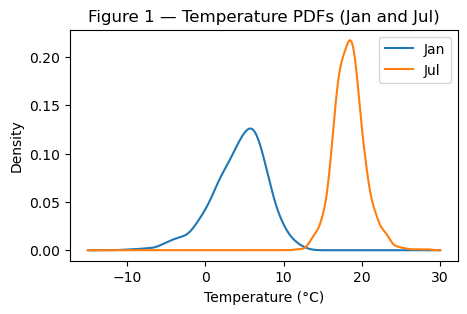

In [17]:
# ========= Monthly splits & KDEs =========
# split weather into 12 months
listOfMonthData = []
for i in range(1, 13):
    listOfMonthData.append(weather.loc[weather["Month"] == i, ["temperature", "precipitation", "humidity"]].dropna())

class Month:
    def __init__(self, index, month_pdf_T, month_pdf_P, month_pdf_H):
        self.index = index # 1 indexed from January
        self.month_pdf_T, self.month_pdf_P, self.month_pdf_H = month_pdf_T, month_pdf_P, month_pdf_H
        
# build KDEs per month
listOfMonthPDFs = []
for i in range(12):
    month = listOfMonthData[i]
    pdf_T, pdf_P, pdf_H = stats.gaussian_kde(month["temperature"]), stats.gaussian_kde(month["precipitation"]), stats.gaussian_kde(month["humidity"])
    listOfMonthPDFs.append(Month(str(i+1), pdf_T, pdf_P, pdf_H))

# spaces to evaluate estimated PDFs over
gT, gP, gH = np.linspace(-15, 30, 400), np.linspace(0, 60, 400), np.linspace(20, 100, 400)

# Figure 1
plt.figure(figsize=[5, 3])
plt.plot(gT, listOfMonthPDFs[0].month_pdf_T(gT))
plt.plot(gT, listOfMonthPDFs[6].month_pdf_T(gT))
plt.legend(["Jan", "Jul"])
plt.xlabel("Temperature (°C)")
plt.ylabel("Density")
plt.title("Figure 1 — Temperature PDFs (Jan and Jul)")
plt.show()

Specify the daily customer amount equation as

$$C_d(T_d,P_d,H_d)=\max\{\,C_0 + a\,(T_d-T_0)^2 - b\,(P_d-P_0) - c\,(H_d-H_0)^2,\ 0\,\}$$

- We chose $T_0,P_0,$ and $H_0$ to be the mean value for each of the respective weather measurements over the entire dataset. The justification for this is that from the structure of the equation if the inputted values ($T_d,P_d,H_d$) are exactly equal to each respective parameter ($T_0,P_0,$ and $H_0$) the amount of customers for that day will just be equal to $C_0$. Therefore the reference values should represent what typical weather looks like, and the mean value is the statistic that does that.


- We get **Jan/Jul mean weather** from the KDEs (numerical mean via integration on a fine grid).  
- We estimate $a,b,c$ using a finite-difference idea based on the **change in average daily customers** from January to July.  

- We chose $C_0$ to be the mean between the average daily number of customers for January and the average daily number of customers for July.

**Estimating the coefficients:**

We know the customer response model as defined above: 
$$C_d(T_d,P_d,H_d)= C_0 + a(T_d - T_0)^2 - b(P_d - P_0) - c(H_d - H_0)^2$$
where $C_0$ is the baseline value at reference weather $(T_0,P_0,H_0)$, and $a,b,c$ represent sensitivities to temperature, precipitation, and humidity.

Let $$\Delta C = C_{Jul} - C_{Jan}$$
be the observed change in average daily customers between January and July, let $(T_{Jan}, P_{Jan}, H_{Jan})$ and $(T_{Jul}, P_{Jul}, H_{Jul})$ denote the corresponding mean weather conditions.

Coefficient $a$:

Assume, for the purpose of isolating the effect of temperature, that precipitation and humidity remain at their reference levels while temperature moves from its January mean to its July mean. Then the change predicted by the model is
$$\Delta C \approx a [(T_{Jul} - T_0)^2 - (T_{Jan} - T_0)^2] \implies a = \dfrac{\Delta C}{(T_{Jul} - T_0)^2 - (T_{Jan} - T_0)^2}$$

Coefficient $b$:

To isolate precipitation, assume temperature and humidity remain at $T_0$ and $H_0$. The model then yields
$$\Delta C \approx b [(P_{Jul} - P_0) - (P_{Jan} - P_0)] \implies b = \dfrac{\Delta C}{(P_{Jul} - P_0) - (P_{Jan} - P_0)}$$

Coefficient $c$:

Similarly, holding temperature and precipitation at their reference levels gives
$$\Delta C \approx c [(H_{Jul} - H_0)^2 - (H_{Jan} - H_0)^2] \implies c = \dfrac{\Delta C}{(H_{Jul} - H_0)^2 - (H_{Jan} - H_0)^2}$$

Justification: Because we only have customer data for two months, we cannot reliably fit all three weather effects at the same time. Instead, we use a simple one-variable-at-a-time approach: we treat the change in customers from January to July as if it were caused by the change in just one weather variable (temperature, precipitation, or humidity), keeping the others fixed at their typical values. Solving the model under these simplified comparisons gives the formulas for $a,b,$ and $c$. This produces reasonable, interpretable estimates given the limited data.

In [18]:
# ========= Customer model c(T,P,H) and parameter estimates =========
# reference levels (long-run means)
t0, p0, h0 = np.mean(weather["temperature"]), np.mean(weather["precipitation"]), np.mean(weather["humidity"])

# function to extract mean from a KDE on a grid of x vals
def kde_mean(kde, grid):
    pdf_vals = kde(grid)
    return np.trapezoid(grid * pdf_vals, grid)

# Jan/Jul means from KDEs
jan_mean_temp, jul_mean_temp = kde_mean(listOfMonthPDFs[0].month_pdf_T, gT), kde_mean(listOfMonthPDFs[6].month_pdf_T, gT)
jan_mean_precip, jul_mean_precip = kde_mean(listOfMonthPDFs[0].month_pdf_P, gP), kde_mean(listOfMonthPDFs[6].month_pdf_P, gP)
jan_mean_humid, jul_mean_humid = kde_mean(listOfMonthPDFs[0].month_pdf_H, gH), kde_mean(listOfMonthPDFs[6].month_pdf_H, gH)

# daily customers in Jan/Jul from hourly totals
JAN_DAYS, JUL_DAYS = 31, 31
January_Total_Customers_Loafe, July_Total_Customers_Loafe = cust["Jan_total"].sum(), cust["Jul_total"].sum()
Avg_Daily_Customers_Jan, Avg_Daily_Customers_Jul = January_Total_Customers_Loafe / JAN_DAYS, July_Total_Customers_Loafe / JUL_DAYS
avg_daily_customer_change = Avg_Daily_Customers_Jul - Avg_Daily_Customers_Jan

# estimate a, b, c 
a = avg_daily_customer_change / ((jul_mean_temp - t0)**2 - (jan_mean_temp - t0)**2)
b = avg_daily_customer_change / ((jul_mean_precip - p0) - (jan_mean_precip - p0))
c = avg_daily_customer_change / ((jul_mean_humid - h0)**2 - (jan_mean_humid - h0)**2)

# baseline customer's
c0 = 0.5*(Avg_Daily_Customers_Jan + Avg_Daily_Customers_Jul)

print(f"Reference mean averages: T0={t0:.2f}°C, P0={p0:.2f}mm, H0={h0:.2f}%")
print(f"Jan vs Jul daily customers: {Avg_Daily_Customers_Jan:.1f} → {Avg_Daily_Customers_Jul:.1f}")
print(f"a={a:.3f}, b={b:.3f}, c={c:.3f}, C0={c0:.1f}")

# model
def cFunc(TempDay, PrecipitationDay, HumidityDay):
    val = c0 + a*(TempDay - t0)**2 - b*(PrecipitationDay - p0) - c*(HumidityDay - h0)**2
    return max(val, 0.0)

Reference mean averages: T0=10.60°C, P0=3.19mm, H0=78.10%
Jan vs Jul daily customers: 350.4 → 175.4
a=-8.121, b=36.557, c=-14.826, C0=262.9


## Yearly Simulation

We simulate a **typical** (non-leap) year by:
- mapping day $d \in \{1..365\}$ to its **month**,  
- drawing a single $(T,P,H)$ sample from that month’s PDFs,  
- applying $C_d(T_d,P_d,H_d)$, and  
- multiplying by a constant $s$ $ **spend per customer**.

**Note:**
At the Sauder Loafe location, the average price for a food item is $\$13.73$ and the average price for a drink is $\$5.74$. If we assume that 25% of customers buy only food, 50% buy only a drink, and 25% both food and a drink, we get that the average customer would spend $$s = 0.25*(\$13.73) + 0.5*(\$5.74) + 0.25*(\$13.73 + \$5.74) = \$11.17.$$

This produces a **sample** $R$ of annual revenue that follows the equation $$R = \sum_{d = 1}^{365}C(T_d,P_d,H_d) \times s.$$

In [32]:
# Defining functions

# Used for determining which month to sample weather data from
days_per_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31])  
month_edges = np.cumsum(days_per_month)

# Used for determining which month to sample from
def dayToMonth(day):
    return int(np.searchsorted(month_edges, day)) 

# Daily revune function definition
def dailyRev(month, spend_per_customer):
    T_hat = listOfMonthPDFs[month].month_pdf_T.resample(1).ravel()[0] 
    P_hat = listOfMonthPDFs[month].month_pdf_P.resample(1).ravel()[0]
    H_hat = listOfMonthPDFs[month].month_pdf_H.resample(1).ravel()[0]
    customersDay = cFunc(T_hat, P_hat, H_hat)
    return customersDay * spend_per_customer

# Yearly revenue function definition
def yearlyRev(spend_per_customer):
    total = 0.0
    for i in range(1, 365+1):
        m = dayToMonth(i)
        total += dailyRev(m, spend_per_customer=spend_per_customer)
    return total
    
s=11.17
yearRev = yearlyRev(s)
print(f"Sample R revenue/year (s=${s:.2f}): ${yearRev:,.0f}")

Sample R revenue/year (s=$11.17): $5,320,764


## Monte Carlo Estimation

Below is a unperturbed Monte Carlo simulation of our yearly revunue:

In [ ]:
N = 500 # simulate 500 years of revune
yearlyRevenues = [yearlyRev(s) for _ in range(N)] # list unpacking python notation

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.hist(yearlyRevenues, density=True, bins=50)
ax.set_title("Annual revenue (Monte Carlo)")
ax.set_xlabel("Revenue (CAD)"); ax.set_ylabel("Density")
plt.tight_layout()

In [ ]:
yr = np.array(yearlyRevenues)
q5, q50, q95 = np.percentile(yr, [5, 50, 95])
mean = np.mean(yr)
print(f"Mean annual revenue: ${mean:,.0f} |Median annual revenue: ${q50:,.0f} | 90% CI: [${q5:,.0f}, ${q95:,.0f}]")

**Below is a perturbed Monte Carlo simulation**

To acknowledge limited Jan/Jul labels, we run a **Monte Carlo** simulation:

- perturb $a,b,c,C_0,T_0,P_0,H_0$ by adding modest Gaussian noise,  
- resample weather each day from the month’s KDEs,  
- compute the annual revenue, and repeat $N=1000$ times.

We then visualize the distribution (Figure 3) and report the median and a 90% interval.

In [ ]:
# parameter sigmas
t0_err, p0_err, h0_err = np.std(weather['temperature']), np.std(weather['precipitation']), np.std(weather['humidity'])
c0_err = np.std((np.append(cust['Jan_total'], cust['Jul_total'])))
a_err, b_err, c_err = 0.5, 2.0, 0.2

def dailyRevMC(month, rng, spend_per_customer):
    a_s, b_s, c_s = a + rng.normal(0.0, a_err), b + rng.normal(0.0, b_err), c + rng.normal(0.0, c_err)
    t0_s, p0_s, h0_s, c0_s = t0 + rng.normal(0.0, t0_err), p0 + rng.normal(0.0, p0_err), h0 + rng.normal(0.0, h0_err), c0 + rng.normal(0.0, c0_err)

    T_hat = listOfMonthPDFs[month].month_pdf_T.resample(1).ravel()[0]
    P_hat = listOfMonthPDFs[month].month_pdf_P.resample(1).ravel()[0]
    H_hat = listOfMonthPDFs[month].month_pdf_H.resample(1).ravel()[0]

    val = c0_s + a_s*(T_hat - t0_s)**2 - b_s*(P_hat - p0_s) - c_s*(H_hat - h0_s)**2
    customersDay = max(val, 0.0)
    return customersDay * spend_per_customer

def yearlyRevMC(N=1000, spend_per_customer=s, seed=7):
    rng = np.random.default_rng(seed)
    total = 0.0
    for i in range(1, 365+1):
        m = dayToMonth(i)
        total += dailyRevMC(m, rng, spend_per_customer=s)
    return total

N = 1000
yearlyRevenues = [yearlyRevMC(N, s) for _ in range(N)]


In [ ]:
print("Uncertainty / Error Scales Used in Monte Carlo")
print("--------------------------------------------------")
print(f"T0 error (σ_T0): {t0_err:.3f}  °C")
print(f"P0 error (σ_P0): {p0_err:.3f}  mm")
print(f"H0 error (σ_H0): {h0_err:.3f}  %")
print(f"C0 error (σ_C0): {c0_err:.3f}  customers/day")

print("\nCorresponding variances (σ²):")
print("--------------------------------------------------")
print(f"Var(T0): {t0_err**2:.3f}")
print(f"Var(P0): {p0_err**2:.3f}")
print(f"Var(H0): {h0_err**2:.3f}")
print(f"Var(C0): {c0_err**2:.3f}")

- **Figure 3:** Histogram of annual revenue from Monte Carlo.  
- **Figure 4:** Simple one-dimensional sensitivities of expected customers against each weather variable around the reference levels (helps interpret $a,b,c$).  
We also print the median and 90% interval of revenue.

In [ ]:
# ========= Plot MC histogram & sensitivity mini-panel =========
# fig, ax = plt.subplots(1, 1, figsize=(7, 3))
# ax.hist(yearlyRevenues, density=True, bins=30)
# ax.set_title("Figure 3 — Annual revenue uncertainty (Monte Carlo)")
# ax.set_xlabel("Revenue (CAD)"); ax.set_ylabel("Density")
# plt.tight_layout()

# Figure 4 — simple 1D sensitivities (T,P,H) around reference (overlays in one figure)
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
def _sens_1d(ax, var):
    if var == "T":
        xs = np.linspace(t0-15, t0+15, 200)
        ys = [max(c0 + a*(x - t0)**2 - b*(p0 - p0) - c*(h0 - h0)**2, 0) for x in xs] #some bugs?
        ax.plot(xs, ys); ax.set_xlabel("Temperature (°C)")
        ax.axvline(t0, color="red", linestyle="--", label="T₀ (reference)")
        ax.set_xlabel("Temperature (°C)")
    elif var == "P":
        xs = np.linspace(0, max(60, p0+30), 200)
        ys = [max(c0 + a*(t0 - t0)**2 - b*(x - p0) - c*(h0 - h0)**2, 0) for x in xs]
        ax.plot(xs, ys); ax.set_xlabel("Precipitation (mm)")
        ax.axvline(p0, color="red", linestyle="--", label="P₀ (reference)")
        ax.set_xlabel("Precipitation (mm)")
    ax.set_ylabel("Expected customers/day")
    ax.legend()

_sens_1d(axes[0], "T")
_sens_1d(axes[1], "P")
plt.suptitle("Figure 4 — Local sensitivities around reference weather")
plt.tight_layout()

# summary stats
yr = np.array(yearlyRevenues)
q5, q50, q95 = np.percentile(yr, [5, 50, 95])
print(f"MC median: ${q50:,.0f} | 90% CI: [${q5:,.0f}, ${q95:,.0f}]")


# Analysis and Assessment:

From the sensitivity plots, we see:
- The number of customers changes in the same direction as the sign of $a$ or $-c$ as temperature or humidity deviate further from their reference values.
- The number of customers changes in the same direction as the sign of $-b$ if precipitation is greater than the reference value, or goes the opposite direction if it is less than it.

Reporting some of the statistics from our monte carlo simulation of total annual revune, we have that the average annual revune for Loafe across all locations is BLANK$\text{\$}$ per year, the mode of annual revune is 56,311$\text{\$}$, and the variance is BLANK ($E[x^2]-\mu^2$). Our use of monte carlo analyis here is justified due to the fact that the quantity we are trying to predict is dependant on random varibles(temprature,precepatiation,humidatity), so we must use stochastic numerical methods to construct a good estimate. 